In [11]:
import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Use tkinter to select the Excel file
def select_file():
    Tk().withdraw()
    file_path = askopenfilename(
        title="Select Training Excel File",
        filetypes=[("Excel files", "*.xlsx *.xls"), ("All files", "*.*")]
    )
    return file_path

# Prompt the user
print("Please select the training data file:")
training_excel_file = select_file()

if training_excel_file:
    # Read Excel file
    df_training = pd.read_excel(training_excel_file, sheet_name='Sheet1')
    
    print("Top 5 rows in the training DataFrame:")
    print(df_training.head())
else:
    print("No file selected. Please try again.")

Please select the training data file:
Top 5 rows in the training DataFrame:
   Unnamed: 0  \
0       93203   
1       41610   
2       95154   
3       58051   
4        4906   

                                                                                                    Combined Description  \
0                                              PROVISION OF CATERING SERVICES    [Catering 010 D] Rental of Collin Glass   
1                           PROVISION OF LOGISTICS SERVICES FOR HOME TEAM RETAIL MEGAMART (HTRM)   LOUD HAILER  (5 DAYS)   
2     WOG Video and Animation Period Contract and Framework Agreement - 4th Edition    A34 - Third Party Management Cost   
3                 PROVISION OF LOGISTICS SERVICES FOR HOME TEAM RETAIL MEGAMART (HTRM)   AUDIT &  STOCKTAKING MAN-EFFORT   
4                                                                  SUPPLY OF CALL CENTRE SYSTEM WITH MAINTENANCE FOR TP    

                                                             Commitment item

**Data cleansing**

In [12]:
import json

# Load materials.json
with open('../data/processed/materials.json', 'r') as file:
    materials_data = json.load(file)

# Convert materials.json into a lookup dictionary for efficient matching
materials_lookup = {item['material_number']: item['description'] for item in materials_data}

# Ensure the necessary columns exist
if 'Combined Description' not in df_training.columns or 'Commitment item' not in df_training.columns:
    raise ValueError("The training Excel file must contain 'Combined Description' and 'Commitment item' columns.")

# Data cleansing: Remove null values and strip whitespace
df_training = df_training.dropna(subset=['Combined Description', 'Commitment item'])
df_training['Combined Description'] = df_training['Combined Description'].str.strip()

# Extract material_number from 'Commitment item' and map to descriptions
df_training['material_number'] = df_training['Commitment item'].str.split(' - ', expand=True)[0]
df_training['description'] = df_training['material_number'].map(materials_lookup)

# Drop the original 'Commitment item' column
df_training = df_training.drop(columns=['Commitment item'])

# Display the cleaned DataFrame
print("\nCleaned training DataFrame:")
print(df_training[['material_number', 'description', 'Combined Description']].head())



Cleaned training DataFrame:
  material_number  \
0          212901   
1          212401   
2          218999   
3          218999   
4          226301   

                                                   description  \
0                                          Rental-Other Assets   
1                                       Rental-Other Equipment   
2                                     Other Services(OOE only)   
3                                     Other Services(OOE only)   
4  Maintenance-ICT Hardware Integrated with Software(OOE only)   

                                                                                                 Combined Description  
0                                           PROVISION OF CATERING SERVICES    [Catering 010 D] Rental of Collin Glass  
1                        PROVISION OF LOGISTICS SERVICES FOR HOME TEAM RETAIL MEGAMART (HTRM)   LOUD HAILER  (5 DAYS)  
2  WOG Video and Animation Period Contract and Framework Agreement - 4th Edition    A34

**Vector embedding of materials.json**

In [63]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src import search
json_file = '../data/processed/services.json'

# Initialize the search engine with reference data
search_engine = search.SentenceTransformerSearch(data_file=json_file)

print("\nVector embedding completed for reference data")


Vector embedding completed for reference data


**Evaluate model, save to dataframe**

In [64]:
from sklearn.model_selection import train_test_split
from src.search import evaluate_model

# Split the data 
train_df, test_df = train_test_split(df_training, test_size=0.5, random_state=42)

# Evaluate the model    
results = evaluate_model(search_engine, train_df, top_k=5)

# Convert the results to a DataFrame 
df_default = pd.DataFrame(results)
df = df_default
print("\nEvaluation completed. Results DataFrame:")
print(df.head(1))


Evaluation completed. Results DataFrame:
                                                                                                                                                                                                                                                                                                  query  \
0  Provision of Generic Application Support (GAS) for (3+3) Years [Tender No: MHA00003000010059] [Contract No: MHA00004000007582]    [Firm] (Additional Services) Framework Agreement for Application Development, Maintenance and Support Services for 3 Years -  Category B [Please refer to GAS ZFA]   

  expected                 expected_description  \
0   217301  Tech Services-Software as a Service   

                                                                                                                                                                                                                                                                

**General Metrics**

In [77]:
import pandas as pd
from IPython.display import display, HTML

# Flatten the retrieved descriptions
def extract_retrieved_descriptions(row):
    return [match['description'] for match in row['retrieved_top_5']]

# Add a 'retrieved_descriptions' column
df['retrieved_descriptions'] = df.apply(extract_retrieved_descriptions, axis=1)

# Calculate overall metrics
total_records = len(df)
total_correct = df['is_correct'].sum()
total_incorrect = total_records - total_correct
accuracy = total_correct / total_records if total_records > 0 else 0

# Display the overall metrics
print("Overall Metrics:")
print(f"Total Records: {total_records}")
print(f"Total Correct: {total_correct}")
print(f"Total Incorrect: {total_incorrect}")
print(f"Accuracy: {accuracy:.3f}")

# Filter incorrect records
incorrect_records = df[~df['is_correct']]

# Select required columns for display
columns_to_display = ['query', 'expected_description', 'retrieved_descriptions']

# Display incorrect records as a table
print("\nIncorrect Records:")
custom_style = """
<style>
    td:nth-child(1), td:nth-child(2), td:nth-child(3) {text-align: left;} /* Align key text columns to the left */
</style>
"""

html_table = incorrect_records[columns_to_display].to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
styled_html = f"{custom_style}{html_table}"

# Render as HTML
display(HTML(styled_html))

# Export incorrect records to an Excel file
output_path = "../data/output/incorrect_records_analysis.xlsx"
incorrect_records_to_export = incorrect_records[columns_to_display]
incorrect_records_to_export.to_excel(output_path, index=False, engine='openpyxl')

print(f"Incorrect records exported to: {output_path}")


Overall Metrics:
Total Records: 7266
Total Correct: 5947
Total Incorrect: 1319
Accuracy: 0.818

Incorrect Records:


query,expected_description,retrieved_descriptions
"Provision of Generic Application Support (GAS) for (3+3) Years [Tender No: MHA00003000010059] [Contract No: MHA00004000007582] [Firm] (Additional Services) Framework Agreement for Application Development, Maintenance and Support Services for 3 Years - Category B [Please refer to GAS ZFA]",Tech Services-Software as a Service,"[[Tech Services-Other ICT Services, FRAMEWORK AGREEMENT FOR THE PROVISION OF INFOCOMM TECHNOLOGY, ENGINEERING], Fixed Asset Purchase-ICT Software (Project), Fixed Asset Purchase-Other Ops Tech Sys (Project), Fixed Asset Purchase-Motor Vehicles (Project), [Other Services-Other Services, WOG Video and Animation Period Contract, WOG Translation and Related Services, WOG Research Services and Period Contract, WOG PERIOD CONTRACT AND FRAMEWORK AGREEMENT]]"
"SUPPLY, DELIVERY, INSTALLATION, TESTING, COMMISSIONING OF INTRUSION PREVENTION SYSTEM AND VIRTUAL PRIVATE NETWORK APPLIANCE WITH 4 YEARS OF COMPREHENSIVE MAINTENANCE 4 Years Comprehensive Maintenance for VPN",Maintenance-ICT Hardware Integrated with Software(OOE only),"[[Tech Services-ICT Security/Audit Services, PROVISION OF A BULK TENDER ON CYBERSECURITY AND AUDIT SERVICES], Maintenance-ICT Hardware(OOE only), Maintenance-Operations Technology Systems(OOE only), Maintenance-ICT Software(OOE only), Maintenance-Motor Vehicles(OOE only)]"
SS n Mce of Drug Analysis Device 7 YR Post-Warranty Preventive Mce for Portable Drug Analysis Kit,Maintenance-Other Equipment & Tools(OOE only),"[Maintenance-Scientific Equipment(OOE only), Service for Safety & Medical Supplies(OOE only), Fixed Asset Purchase-Office Equipment (Projcet), Fixed Asset Purchase-Scientific Equipment (Project), Maintenance-Office Equipment(OOE only)]"
PROVISION OF BOLLARDS AND SWING GATE AT BOAT QUAY REPLACEMENT OF EXISTING SWING GATE WITH GALVANIZED STEEL SWING GATE,Maintenance-Mechanical & Electrical System of Building(OOE only),"[Maintenance-Public Parks(OOE only), Maintenance-Bridges/Underpasses(OOE only), Cyclical Replacement-Building(OOE only), Maintenance-Vessels(OOE only), Maintenance-Land Transport Facilities(OOE only)]"
,Staff Well-Being(OOE only),"[Other Services-Fees to Board Members/Directors/ Committee, Fixed Asset Purchase-Land Transport Facilities (Project), Fixed Asset Purchase-Heavy Construction Machinery (Project), Fixed Asset Purchase-Water Treatment Plants & Equipment (Project), Fixed Asset Purchase-Unmanned Aerial Vehicles (Project)]"
"Period Contract for the Supply, Design, Development, Delivery, Installation, Implementation, Training, Testing and Commissioning of a Recall System with Maintenance for Singapore Civil Defence Force (Annual Disaster Recovery Exercise, Service Request Man-Days and Service Support Man-Hours Outside Support Hours) [VA No. 3] Annual Disaster Recovery Exercise (Pay-Per-Use)",Rental-Other Assets,"[[Other Services-Other Services, WOG Video and Animation Period Contract, WOG Translation and Related Services, WOG Research Services and Period Contract, WOG PERIOD CONTRACT AND FRAMEWORK AGREEMENT], Fixed Asset Purchase-Office Equipment (Projcet), Maintenance-Operations Technology Systems(OOE only), Maintenance-Land(OOE only), Maintenance-Motor Vehicles(OOE only)]"
"Raw materials for SPF's GC And PCG for Year 3 Year 3 from 1.11.22 - 31.10.23 Black Plum, kg",Service for Meals & Refreshments(OOE only),"[Fixed Asset Purchase-Scientific Equipment (Project), Fixed Asset Purchase-Incineration Plants (Project), Professional Services-Security Services for Buildings, Maintenance-Scientific Equipment(OOE only), Cyclical Replacement-Mechanical & Electrical System of Building(OOE only)]"
COMPREHENSIVE MAINTENANCE OF TWO (2) UNITS OF SERVICE LIFTS FOR HOME TEAM TACTICAL CENTRE (HTTC) FOR A BASE PERIOD OF FIVE (5) YEARS WITH AN OPTION TO EXTEND FOR ANOTHER TWO (2) YEARS. COMPREHENSIVE MAINTENANCE OF TWO (2) UNITS OF SERVICE LIFTS FOR HOME TEAM TACTICAL CENTRE (HTTC) FOR A BASE PERIOD OF 5 YEARS,Maintenance-Mechanical & 

Incorrect records exported to: ../data/output/incorrect_records_analysis.xlsx


## Analysis 2: which service numbers are performing well and why?

**for the top performers compute precision as well as the correct/incorrect predictions**<br>
How metrics are previously calculated:<br>
In the previous calculations, even if a record is classified as "correct" for one of the top 5 values matching the expected service number, any other service numbers present in the top 5 that are not the expected service number will contribute to their own incorrect count.<br>

This may not make much sense as it might inflate the model's incorrectness <br>

How they are calculated now:<br>
If in one record, any of the top 5 matches the expected, then it would not add to the incorrect count for the other 4 service numbers

In [66]:
import pandas as pd
from IPython.display import display, HTML  

# Flatten the data into a DataFrame
df_copy = pd.DataFrame([
    {
        "query": entry["query"],
        "expected": entry["expected"],
        "expected_description": entry["expected_description"],  
        "retrieved_material_number": retrieved["material_number"],
        "retrieved_description": retrieved["description"],
        "score": retrieved["score"],
        "is_correct": retrieved["material_number"] == entry["expected"]
    }
    for entry in df.to_dict("records") 
    for retrieved in entry["retrieved_top_5"]
])

'''
Why True Negatives Don't Apply
In this context:

- The model is not tasked with determining what doesn’t belong.
- There is no explicit prediction or evaluation for items outside the top 5.
- Therefore, true negatives are not meaningful.
'''

# Exclude matches if any in the top 5 is correct
df_copy['query_correct'] = df_copy.groupby('query')['is_correct'].transform('max')

# Calculate metrics for each service number, including hit rate
service_metrics = []
for material_number, group in df_copy.groupby("retrieved_material_number"):
    total_correct = group["is_correct"].sum()
    total_incorrect = group[(group['query_correct'] == 0)].shape[0]
    false_negatives = len(df_copy[(df_copy["expected"] == material_number) &
                                  (~df_copy["retrieved_material_number"].eq(material_number))])

    precision = total_correct / (total_correct + total_incorrect) if (total_correct + total_incorrect) > 0 else 0
    accuracy = total_correct / len(group)
    #accuracy = total_correct / (total_correct + total_incorrect + false_negatives) if (total_correct + total_incorrect + false_negatives) > 0 else 0
    hit_rate = len(group)

    description = group["retrieved_description"].iloc[0]

    # Append metrics for this service number
    service_metrics.append({
        "service_number": material_number, 
        "hit_rate": hit_rate,
        "total_correct": total_correct,
        "total_incorrect": total_incorrect,
        "precision": round(precision, 3),  
        "accuracy": round(accuracy, 3),   
        "description": description
    })

metrics_df = pd.DataFrame(service_metrics)
metrics_df = metrics_df.sort_values(by="precision", ascending=False)

custom_style = """
<style>
    td:nth-child(7) {text-align: left;}
</style>
"""
html_table = metrics_df.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
styled_html = f"{custom_style}{html_table}"

# Display the styled HTML table
display(HTML(styled_html))


service_number,hit_rate,total_correct,total_incorrect,precision,accuracy,description
212401,4693,3205,411,0.886,0.683,"[Rental-Other Equipment, PROVISION OF LOGISTICS SERVICES]"
218999,4656,1387,378,0.786,0.298,"[Other Services-Other Services, WOG Video and Animation Period Contract, WOG Translation and Related Services, WOG Research Services and Period Contract, WOG PERIOD CONTRACT AND FRAMEWORK AGREEMENT]"
215201,377,100,38,0.725,0.265,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]"
212901,966,377,156,0.707,0.390,"[Rental-Other Assets, PROVISION OF CATERING SERVICES non-food items, Provision of Security Services Package, PROVISION OF CARDIAC HEALTH SCREENING SERVICES, Video Wall Systems Schedule of Rates]"
213201,926,306,139,0.688,0.330,"[Service for Meals & Refreshments(OOE only), PROVISION OF CATERING SERVICES food items]"
218401,854,235,119,0.664,0.275,"[Other Services-Postage and Courier Services, PROVISION OF COURIER SERVICES, Provision of Direct Mailing Services]"
213101,1433,156,119,0.567,0.109,"[Service for Office Supplies(OOE only), Leasing of Digital Copiers]"
217501,289,124,98,0.559,0.429,"[Tech Services-ICT Security/Audit Services, PROVISION OF A BULK TENDER ON CYBERSECURITY AND AUDIT SERVICES]"
226301,3,1,1,0.500,0.333,Maintenance-ICT Hardware Integrated with Software(OOE only)
225901,226,64,75,0.460,0.283,"[Maintenance-Other Equipment & Tools(OOE only), SUPPLY AND MAINTENANCE OF FIRE FIGHTING EQUIPMENT]"


In [67]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# Ensure the expected column exists in df
if 'expected' not in df.columns:
    raise KeyError("The 'expected' column does not exist in the DataFrame.")

# Count the occurrences of each service number in the 'expected' column
service_number_counts = df['expected'].value_counts().reset_index()
service_number_counts.columns = ['service_number', 'count']

# Render the counts as an HTML table
custom_style = """
<style>
    td:nth-child(1), td:nth-child(2) {text-align: left;} /* Align service number and count to the left */
</style>
"""
html_table = service_number_counts.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
styled_html = f"{custom_style}{html_table}"

# Display the table
print("\nMost Frequent Service Numbers in the 'expected' Column:")
display(HTML(styled_html))



Most Frequent Service Numbers in the 'expected' Column:


service_number,count
212401,3208
218999,1277
212901,576
213201,335
218401,235
225901,191
213101,157
217901,137
226301,132
217501,124


In [68]:
import pandas as pd
from difflib import SequenceMatcher
from collections import defaultdict
from IPython.display import display, HTML

# Function to find similarity between strings
def find_common_prefix(strings, min_length=10):
    """Find the common prefix across a list of strings."""
    if not strings:
        return ""
    common_prefix = strings[0]
    for s in strings[1:]:
        matcher = SequenceMatcher(None, common_prefix, s)
        match = matcher.find_longest_match(0, len(common_prefix), 0, len(s))
        if match.size < min_length:
            return ""
        common_prefix = common_prefix[match.a: match.a + match.size]
    return common_prefix.strip()

# Function to merge similar groups
def merge_similar_groups(grouped_df, similarity_threshold=0.8):
    """Merge groups in grouped_df if their common prefixes are similar."""
    merged_groups = defaultdict(int)
    for _, row in grouped_df.iterrows():
        common_prefix = row["Common Prefix"]
        found_match = False
        for key in list(merged_groups.keys()):
            if SequenceMatcher(None, common_prefix, key).ratio() >= similarity_threshold:
                merged_groups[key] += row["Query Count"]
                found_match = True
                break
        if not found_match:
            merged_groups[common_prefix] = row["Query Count"]
    return pd.DataFrame(merged_groups.items(), columns=["Common Prefix", "Query Count"])

# Input service number to analyze
service_number_to_analyze = input("Enter the service number to analyze: ").strip()

if not service_number_to_analyze.isdigit():
    print("Invalid input! Please enter a valid numeric service number.")
else:
    # Filter the records to contain only those with the service number in the 'expected' column
    filtered_records = df[df['expected'] == service_number_to_analyze]
    
    if filtered_records.empty:
        print(f"No records found for Service Number: {service_number_to_analyze}")
    else:
        print(f"\nAnalyzing query patterns for Service Number: {service_number_to_analyze}\n")

        # Group queries based on their front portion similarity
        query_groups = defaultdict(list)
        queries = filtered_records['query'].tolist()
        
        for query in queries:
            grouped = False
            for group_key, group_list in query_groups.items():
                if SequenceMatcher(None, query, group_key).ratio() >= 0.8:
                    group_list.append(query)
                    grouped = True
                    break
            if not grouped:
                query_groups[query] = [query]

        # Summarize groups with common prefix and count
        summarized_groups = []
        for group_key, group_queries in query_groups.items():
            common_prefix = find_common_prefix(group_queries)
            summarized_groups.append({
                "Common Prefix": common_prefix or group_key[:30],  # Fallback to part of the first query
                "Query Count": len(group_queries)
            })

        grouped_df = pd.DataFrame(summarized_groups).sort_values(by="Query Count", ascending=False)

        # Merge similar groups
        refined_grouped_df = merge_similar_groups(grouped_df)

        # Render as an HTML table
        custom_style = """
        <style>
            td:nth-child(1), td:nth-child(2) {text-align: left;} /* Align columns to the left */
        </style>
        """
        html_table = refined_grouped_df.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
        styled_html = f"{custom_style}{html_table}"

        display(HTML(styled_html))



Analyzing query patterns for Service Number: 215201



Common Prefix,Query Count
Provision of Bus Hiring Services [,72
PROVISION OF LOGISTICS SERVICES FOR HOME TEAM RETAIL MEGAMART (HTRM),21
"Provision of Hiring Services for Cars, VIP Buses and Vans [C",10
- MULTI-PURPOSE VEHICLE WITH S,4
"Provision of Hiring Services for Cars, VIP Buses and Vans [NATIONAL CAR RENTALS (PRIVATE) LIMITED] CAT-",2
"Provision of Hiring Services for Cars, VIP Buses and Vans [STRIDES MOBILITY PTE. LTD.] CAT-D 226 - 22-SEATER VIP BUS - CHAUFFEURRED - PER TRIP",1
Schedule of Rates (SOR) for Year 2 to Year s8 Year 8 Transportation,1
"Provision of Hiring Services for Cars, VIP Buses and Vans [C <(>&<)> P RENT-A-CAR (PTE.) LTD.] CAT-C 149 - HYBRID MULTI-PURPOSE VEHICLE WITH SLIDING DOOR - CHAUFFEURRED - MIDNIGHT SURCHARGE PER HOUR",1
"Provision of Hiring Services for Cars, VIP Buses and Vans [COMFORTDELGRO RENT-A-CAR PTE. LTD.] CAT-C 193 - SPORTS UTILITY VEHICLE - CHAUFFEURRED - PEAK SEASON SURCHARGE PER HOUR",1
CHARTERING OF HARBOUR CRAFT TO FERRY ARMED AUXILIARY POLICE OFFICERS Chartering of Harbour Craft Service,1


**Query analysis of selected service number**

Total Correct: 100
Total Incorrect: 277
Accuracy: 0.265



C:\Users\User\AppData\Local\Temp\ipykernel_17432\1246849206.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_queries['query_length'] = service_queries['query'].str.len()


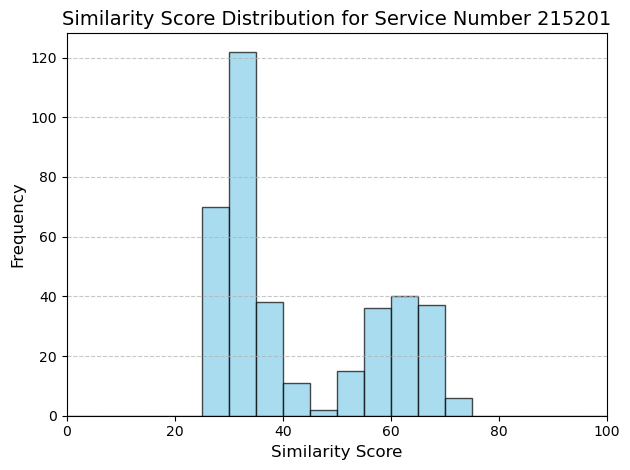

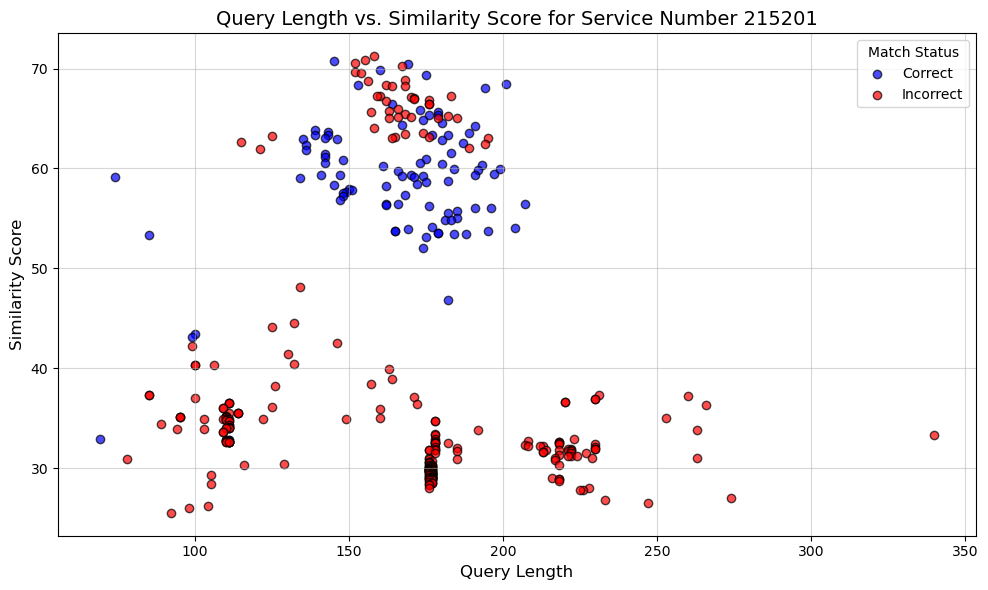


Keyword Analysis for Service Number: 215201
Description: ['Travel & Transport-Local(OOE only)', 'Provision of Hiring Services for Cars, Buses and Vans']



keyword,correct_count,incorrect_count
services,99,263
provision,99,256
hiring,91,43
cat,89,78
pte,79,33
bus,74,4
seater,72,4
service,71,5
ad,70,15
notice,70,0


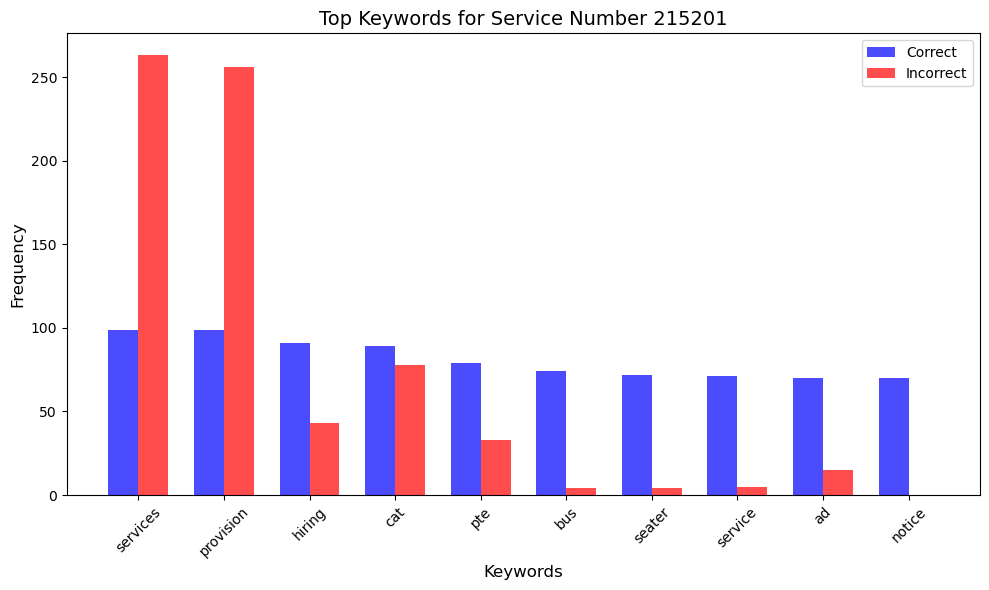


Analysis of Queries for Service Number: 215201


query,query_length,expected_description,retrieved_description,score,is_correct
"Provision of Hiring Services for Cars, VIP Buses and Vans [C <(>&<)> P RENT-A-CAR (PTE.) LTD.] CAT-E 241 - PASSENGER VAN - SELF DRIVE WITH EXCESS - PER DAY",158,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",71.24,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [COMFORTDELGRO RENT-A-CAR PTE. LTD.] CAT-F 254 - GOODS VAN - SELF DRIVE ZERO EXCESS - PER YEAR",155,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",70.81,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [LEISURE FRONTIER (S) PTE. LTD.] CAT-F 253 - GOODS VAN - SELF DRIVE ZERO EXCESS - PER MONTH",152,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",70.56,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [C <(>&<)> P RENT-A-CAR (PTE.) LTD.] CAT-C 181 - SPORTS UTILITY VEHICLE - SELF DRIVE ZERO EXCESS - PER DAY",167,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",70.21,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [LEISURE FRONTIER (S) PTE. LTD.] CAT-F 258 - GOODS VAN - SELF DRIVE WITH EXCESS - PER MONTH",152,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",69.62,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [COMFORTDELGRO RENT-A-CAR PTE. LTD.] CAT-F 256 - GOODS VAN - SELF DRIVE WITH EXCESS - PER DAY",154,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",69.57,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [C <(>&<)> P RENT-A-CAR (PTE.) LTD.] CAT-C 187 - SPORTS UTILITY VEHICLE - SELF DRIVE WITH EXCESS - PER WEEK",168,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",68.81,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [COMFORTDELGRO RENT-A-CAR PTE. LTD.] CAT-F 258 - GOODS VAN - SELF DRIVE WITH EXCESS - PER MONTH",156,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",68.78,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [C <(>&<)> P RENT-A-CAR (PTE.) LTD.] CAT-B 61 - GRADE 2 SALOON CAR - SELF DRIVE ZERO EXCESS - PER DAY",162,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",68.38,False
"Provision of Hiring Services for Cars, VIP Buses and Vans [COMFORTDELGRO RENT-A-CAR PTE. LTD.] CAT-C 187 - SPORTS UTILITY VEHICLE - SELF DRIVE WITH EXCESS - PER WEEK",168,Rental-Other Assets,"[Travel & Transport-Local(OOE only), Provision of Hiring Services for Cars, Buses and Vans]",68.28,False


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from IPython.display import display, HTML

pd.set_option('display.max_colwidth', None)

# Function to clean and extract meaningful keywords
def extract_keywords(text):
    """Extract meaningful keywords by removing stop words and non-alphabetic characters."""
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words
    meaningful_words = [word for word in words if word not in ENGLISH_STOP_WORDS]  # Exclude stop words
    return meaningful_words

# Input the service number
service_number_to_analyze = input("Enter the service number to analyze: ").strip()

if not service_number_to_analyze.isdigit():
    print("Invalid input! Please enter a valid numeric service number.")
else:
    service_queries = df_copy[df_copy['retrieved_material_number'] == service_number_to_analyze]
    
    if service_queries.empty:
        print(f"No queries found for Service Number: {service_number_to_analyze}")
    else:
        # Calculate query lengths
        service_queries['query_length'] = service_queries['query'].str.len()

        # Calculate metrics
        total_correct = service_queries['is_correct'].sum()
        total_incorrect = len(service_queries) - total_correct
        accuracy = total_correct / len(service_queries) if len(service_queries) > 0 else 0

        # Display overall metrics
        print(f"Total Correct: {total_correct}")
        print(f"Total Incorrect: {total_incorrect}")
        print(f"Accuracy: {accuracy:.3f}\n")

        # Sort by correctness and similarity score
        service_queries = service_queries.sort_values(by=['is_correct', 'score'], ascending=[True, False])
        service_query_details = service_queries[['query', 'query_length', 'expected_description', 
                                                 'retrieved_description', 'score', 'is_correct']]

        # Render table with custom CSS for alignment
        custom_style = """
        <style>
            td:nth-child(1), td:nth-child(3), td:nth-child(4) {text-align: left;} /* Align text columns to the left */
        </style>
        """
        html_table = service_query_details.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
        styled_html = f"{custom_style}{html_table}"
        
        # Plot similarity score distribution
        plt.hist(service_queries['score'], bins=range(0, 101, 5), color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"Similarity Score Distribution for Service Number {service_number_to_analyze}", fontsize=14)
        plt.xlabel("Similarity Score", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xlim(0, 100)  
        plt.tight_layout()
        plt.show()
        
        # Plot query lengths vs. similarity scores
        plt.figure(figsize=(10, 6))
        plt.scatter(service_queries[service_queries['is_correct']]['query_length'],
                    service_queries[service_queries['is_correct']]['score'],
                    color='blue', label='Correct', alpha=0.7, edgecolors='k')
        plt.scatter(service_queries[~service_queries['is_correct']]['query_length'],
                    service_queries[~service_queries['is_correct']]['score'],
                    color='red', label='Incorrect', alpha=0.7, edgecolors='k')

        # Add legend and labels
        plt.title(f"Query Length vs. Similarity Score for Service Number {service_number_to_analyze}", fontsize=14)
        plt.xlabel("Query Length", fontsize=12)
        plt.ylabel("Similarity Score", fontsize=12)
        plt.legend(title="Match Status", fontsize=10, loc="upper right")
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # Keyword Analysis
        correct_queries = service_queries[service_queries['is_correct']]['query'].apply(lambda q: set(extract_keywords(q)))
        incorrect_queries = service_queries[~service_queries['is_correct']]['query'].apply(lambda q: set(extract_keywords(q)))

        # Flatten the sets and count frequencies
        correct_keywords = Counter([kw for query_keywords in correct_queries for kw in query_keywords])
        incorrect_keywords = Counter([kw for query_keywords in incorrect_queries for kw in query_keywords])

        # Create a DataFrame for keyword comparison
        keywords_df = pd.DataFrame({
            "keyword": list(set(correct_keywords.keys()).union(set(incorrect_keywords.keys()))),
            "correct_count": [correct_keywords.get(k, 0) for k in set(correct_keywords.keys()).union(set(incorrect_keywords.keys()))],
            "incorrect_count": [incorrect_keywords.get(k, 0) for k in set(correct_keywords.keys()).union(set(incorrect_keywords.keys()))]
        }).sort_values(by="correct_count", ascending=False)

        # Display keyword analysis table
        service_description = service_queries["retrieved_description"].iloc[0]  # Get the description of the service number
        print(f"\nKeyword Analysis for Service Number: {service_number_to_analyze}")
        print(f"Description: {service_description}\n")
        display(HTML(keywords_df.head(20).to_html(index=False, max_rows=None)))

        # Plot top 10 meaningful keywords for correct and incorrect queries
        top_keywords = keywords_df.head(10)
        plt.figure(figsize=(10, 6))
        bar_width = 0.35
        index = range(len(top_keywords))

        plt.bar(index, top_keywords['correct_count'], bar_width, label='Correct', color='blue', alpha=0.7)
        plt.bar([i + bar_width for i in index], top_keywords['incorrect_count'], bar_width, label='Incorrect', color='red', alpha=0.7)

        plt.xlabel('Keywords', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f"Top Keywords for Service Number {service_number_to_analyze}", fontsize=14)
        plt.xticks([i + bar_width / 2 for i in index], top_keywords['keyword'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Display the table
        print(f"\nAnalysis of Queries for Service Number: {service_number_to_analyze}")
        display(HTML(styled_html))


**Code below to export results to excel**

In [70]:
# # Prepare data for export
# additional_data = []

# for result in results:  
#     # Combine expected material number and description
#     expected_combined = f"{result['expected']} - {result['expected_description']}"

#     # Combine top 5 matched material numbers into a single string
#     top_matches_combined = "; ".join(
#         [f"{match['material_number']} score:{match['score']}" for match in result["retrieved_top_5"]]
#     )

#     additional_data.append({
#         "query": result["query"],
#         "expected": expected_combined,  
#         "matches": top_matches_combined,  
#         "is_correct": "True" if result["is_correct"] else "False"  
#     })

# additional_df = pd.DataFrame(additional_data)

# output_path = "../data/output/evaluation_results.xlsx"

# # Dynamically get the model name
# model_name = getattr(search_engine, "model_name", "Unknown_Model")
# sheet_name = model_name.replace("/", "_")[:31]  

# os.makedirs(os.path.dirname(output_path), exist_ok=True)

# # Append to the Excel file
# with pd.ExcelWriter(output_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
#     additional_df.to_excel(writer, index=False, sheet_name=sheet_name)

# print(f"Additional results appended to sheet '{sheet_name}' in: {output_path}")

# 